In [1]:
import pandas as pd
import os, time, csv, re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from collections import Counter
import pycountry

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
years = [i for i in range(2003, 2025)]
fontsize={'legend':12, 'text':8, 'labels':8, 'xticks':8}
colors = ["#808080", "k", "r", 'y', 'm', 'b', "#808080", "k", "r", 'y', 'm', 'b']

review_keywords = ['review', 'survey', 'overview', 'meta-analysis', 'systematic review', 
                   'state of the art', 'literature review', 'comparative analysis', 
                   'synthesis', 'bibliometric analysis']
                   
PATH = './results/'.replace('/', '\\')

uniform_article_types = {
    'Review Paper': 'Review Paper',
    'Review': 'Review Paper',
    'Conference Review': 'Review Paper',
    'Article': 'Research Article',
    'article': 'Research Article',
    'Journal Article': 'Research Article',
    'Conference Paper': 'Conference Paper',
    'conference':'Conference Paper',
    'Book Chapter': 'Book Chapter',
    'Research Article': 'Research Article',
    'research-article': 'Research Article',
    'review-article': 'Review Paper',
    'editorial': 'Editorial',
    'poster': 'Poster',
    'short-paper': 'Research Article',
    'survey': 'Survey Paper',
    'ORIGINAL ARTICLE': 'Research Article',
    'ORIGINAL PAPER': 'Research Article',
    'ORIGINAL RESEARCH': 'Research Article',
    'ORIGINAL RESEARCH PAPER': 'Research Article',
    'RESEARCH ARTICLE': 'Research Article',
    'REVIEW': 'Review Paper',
    'Research Articles': 'Research Article',
    'Review Article': 'Review Paper',
    'SPECIAL ISSUE ARTICLE': 'Special Issue Article',
    'SPECIAL ISSUE PAPER': 'Special Issue Paper',
    'SURVEY ARTICLE': 'Survey Paper',
    'none': 'None',
    'Volume: 4'                  :'Research Article',
    'Volume: 7'                  :'Research Article',
    'Volume: 9'                  :'Research Article',
    'Volume: 10'                 :'Research Article',
    'Volume: 11'                 :'Research Article',
    'Volume: 12'                 :'Research Article',
    'Volume: 10, Issue: 2'       :'Research Article',
    'Volume: 11, Issue: 1'       :'Research Article',
    'Volume: 11, Issue: 6'       :'Research Article',
    'Volume: 16, Issue: 8'       :'Research Article',
    'Volume: 18, Issue: 4'       :'Research Article',
    'Volume: 20, Issue: 2'       :'Research Article',
    'Volume: 20, Issue: 6'       :'Research Article',
    'Volume: 21, Issue: 2'       :'Research Article',
    'Volume: 21, Issue: 5'       :'Research Article',
    'Volume: 23, Issue: 4'       :'Research Article',
    'Volume: 24, Issue: 5'       :'Research Article',
    'Volume: 24, Issue: 7'       :'Research Article',
    'Volume: 70, Issue: 3'       :'Research Article',
    'Volume: 72, Issue: 7'       :'Research Article',
    'Volume: 10, Issue: 13'      :'Research Article',
    'Volume: 19, Issue: 18'      :'Research Article',
    'Volume: 19, Issue: 22'      :'Research Article',
    'Volume: 22, Issue: 10'      :'Research Article',
    'Volume: 22, Issue: 13'      :'Research Article',
    'Volume: 23, Issue: 15'      :'Research Article',
    'Volume: 24, Issue: 10'      :'Research Article',
    'Volume: 24, Issue: 15'      :'Research Article',
    'Volume: 37, Issue: 11'      :'Research Article',
    'Volume: 7, Issue: 10'       :'Research Article',
    'Volume: 8, Issue: 10'       :'Research Article',
    'Volume: 8, Issue: 14'       :'Research Article',
    'Volume: 9, Issue: 19'       :'Research Article',
    'Volume: 8, Issue: 4'        :'Research Article',
    'Volume: 9, Issue: 5'        :'Research Article',
    'Volume: 9, Issue: 6'        :'Research Article'
}

def subcategorybar(
    X, 
    vals, 
    colors, 
    labels, 
    markers='^', 
    width=0.8, 
    major=1000, 
    minor=500, 
    bar=True, 
    plot=False, 
    spines=False, 
    rotation=45,
    fontsize=fontsize,
    show_text=False,
    title=''
):
    n = len(vals)
    _X = np.arange(len(X))
    fig, ax = plt.subplots(figsize=(8, 5), dpi=250)
    for i in range(n):
        print(f"L: {labels[i]} | colors : {colors[i]} | {i} | {vals[i]}")
        if bar:
            bars = ax.bar(
                _X - width/2. + i/float(n)*width, 
                vals[i], 
                width=width/float(n), 
                align="edge",
                color=colors[i],
                label=labels[i]
            )   
            if show_text:
                for bar in bars:
                    yval = bar.get_height()
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,  # X position
                        yval + 0.1,  # Y position (slightly above the bar)
                        round(yval, 2),  # The value of the bar, rounded to 2 decimals
                        ha='center',  # Horizontal alignment
                        va='bottom',  # Vertical alignment
                        fontsize=fontsize['text']  # Font size
                    )
        if plot:
            print(markers)
            ax.plot(_X , vals[i], marker = markers[i], lw=0.45, color=colors[i], label=labels[i], mfc='none', markersize=5)
            plt.grid()

    plt.xticks(_X, X)
    
    ax.yaxis.set_minor_locator(MultipleLocator(minor))
    ax.set_xticks(range(0, len(X)), X, rotation=rotation, fontsize=fontsize['xticks'])
    ax.yaxis.set_major_locator(MultipleLocator(major))
    ax.spines[['right', 'top']].set_visible(spines)
    if len(title) != 0:
        ax.set_title(title)
    plt.legend(fontsize=fontsize['legend'])
    plt.tight_layout()

def process_publish_date(df):
    for i in range(len(df.index)):
        temp = df.loc[i, 'publish_date']
        temp_datetime = pd.to_datetime(temp, format='%d %B %Y', errors='coerce')  # Try 'day Month year'

        if pd.isnull(temp_datetime):
            temp_datetime = pd.to_datetime(temp, format='%Y-%m-%d', errors='coerce')  # Try 'YYYY-MM-DD'
            # print('YYYY-MM-DD')

        if pd.isnull(temp_datetime):
            temp_datetime = pd.to_datetime(temp, format='Date of Publication: %d %B %Y', errors='coerce')  # Try 'Date of Publication: day Month year'

        if pd.isnull(temp_datetime):
            temp_datetime = pd.to_datetime(temp, format='Date of Publication: %B %Y', errors='coerce')  # Try 'Date of Publication: Month year'

        # If successfully converted, update the dataframe
        if not pd.isnull(temp_datetime):
            df.loc[i, 'publish_date'] = temp_datetime

    df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')      
    return df

def filterDatetime(df):
    try:
        df['publish_date'] = pd.to_datetime(df['publish_date'], format='%d %B %Y', errors='coerce')
    except ValueError:
        df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y-%m-%d', errors='coerce')

    return df

def filterDataframe(df):
    for col in df.columns:
        df[col] = df[col].fillna('none')
    df = df.reset_index(drop=True)
    return df

def filterNumberOfAffiliation(affiliations_string):
    # Use regex to find all affiliations
    affiliations_list = re.findall(r'\((.*?)\)', affiliations_string)
    return len(affiliations_list)

def filterCountries(country_string):
    occurrences = country_string.split(',')
    found_countries = []

    for country in pycountry.countries:
        for occurrence in occurrences:
            if country.name in occurrence:
                found_countries.append(country.name)

    return ','.join(found_countries)

def is_review_paper(row):
    if 'conference' not in row['article_type'].lower():
        text = f"{row['title']} {row['keyword']} {row['abstract']}".lower()
        for word in review_keywords:
            if word in text:
                return 'Review Paper'
    return row['article_type']
def filterArticleType(df):
    df['article_type'] = df.apply(is_review_paper, axis=1)
    df['article_type'] = df['article_type'].replace(uniform_article_types)
    df['number_of_citation'] = df['number_of_citation'].replace({'none':0})
    df['number_of_citation'] = pd.to_numeric(df['number_of_citation'], errors='coerce')
    df['title'] = df['title'].astype('string') 
    df['article_type'] = df['article_type'].astype('string') 
    df['publisher'] = df['publisher'].astype('string') 
    df['keyword'] = df['keyword'].astype('string') 
    df['abstract'] = df['abstract'].astype('string') 
    df['publication_title'] = df['publication_title'].astype('string') 
    df['authors'] = df['authors'].astype('string') 
    df['affiliations'] = df['affiliations'].astype('string') 
    df['countries'] = df['countries'].astype('string') 
    df['number_of_countries'] = pd.to_numeric(df['number_of_countries'], errors='coerce')
    df['number_of_found_property_group'] = pd.to_numeric(df['number_of_found_property_group'], errors='coerce')
    df['number_of_found_properties'] = pd.to_numeric(df['number_of_found_properties'], errors='coerce')
    df['countries'] = df['countries'].apply(filterCountries)
    df['number_of_affiliations'] = df['affiliations'].apply(filterNumberOfAffiliation)
    df = df[df['countries'] != '']
    df = df.reset_index(drop=True)
    return df


def filterDataframe(df):
    for col in df.columns:
        df[col] = df[col].fillna('none')
    df = df.reset_index(drop=True)
    return df

df = pd.read_excel('./acoustic_wave.xlsx')
print(f'Before : {len(df)}')
df = filterDataframe(df)
df = filterArticleType(df)
df = process_publish_date(df)
df['year'] = df['publish_date'].dt.year
print(f'After Solar: {len(df)}')
df.to_excel('acoustic_wave_filtered.xlsx')




Before : 64
After Solar: 60


L: Research Article | colors : #808080 | 0 | [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 10, 17, 0]
L: Conference Paper | colors : k | 1 | [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 2, 8, 8, 0]
L: Review Paper | colors : r | 2 | [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


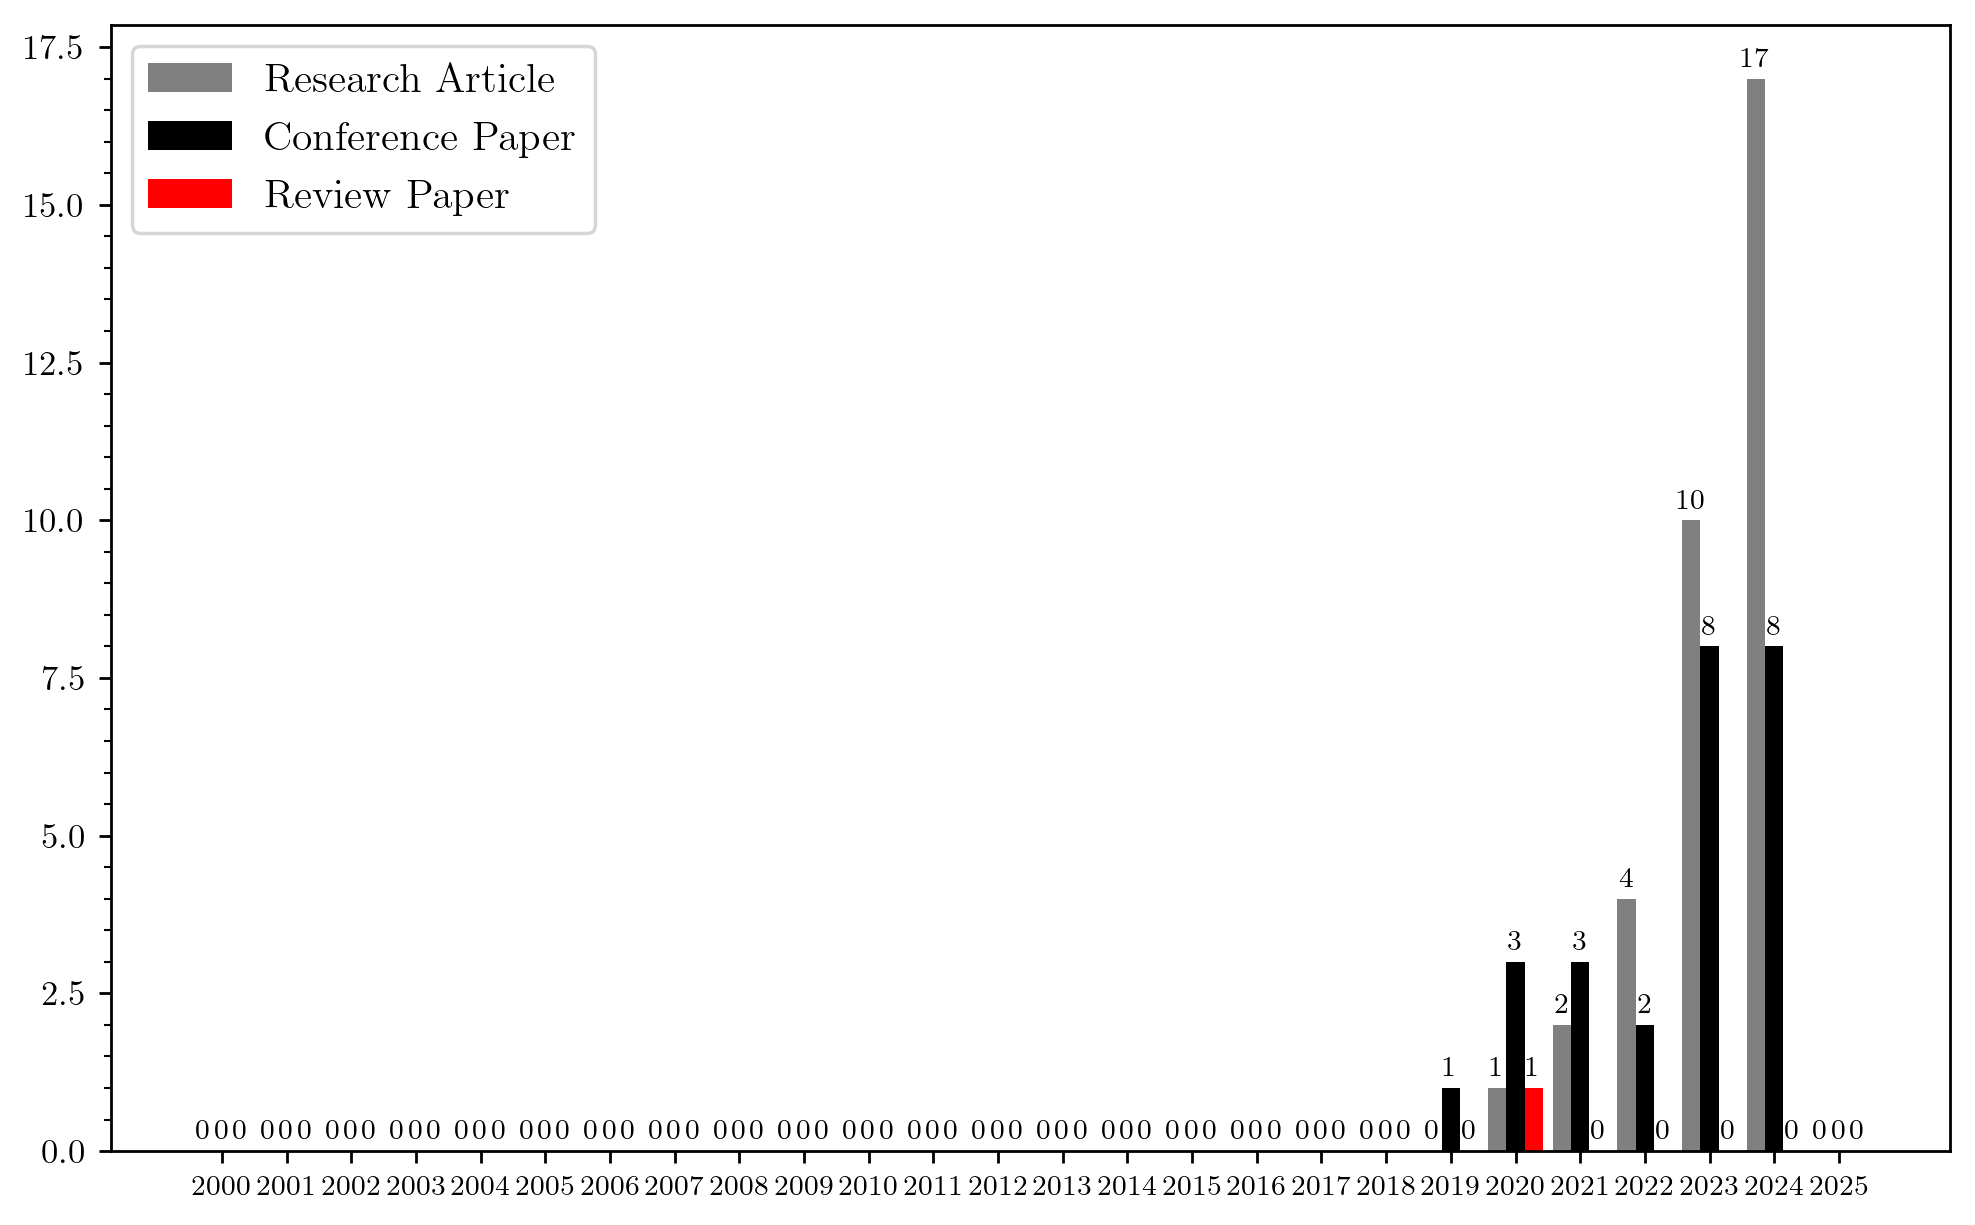

In [3]:
years = [i for i in range(2000, 2026)]
fontsize={'legend':12, 'text':8, 'labels':8, 'xticks':8}
article_types = df.article_type.unique()
data_publication_over_year = {}
for article_type in article_types:
    data_publication_over_year[article_type] = []
    for year in years:
        temp = df.loc[
            (df['year'] == year) & (df['article_type'] == article_type)]['title'].count()
        data_publication_over_year[article_type].append(temp)

subcategorybar(
    years, 
    [data_publication_over_year[article_type] for article_type in data_publication_over_year.keys()], 
    colors, 
    article_types,
    width=0.85, 
    major=2.5, 
    minor=0.5, 
    bar=True, 
    spines=True,
    show_text=True,
    rotation=0,
    fontsize=fontsize
)

C:\Users\user\AppData\Local\Temp\ipykernel_22352\383878352.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_22352\383878352.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_22352\383878352.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_22352\383878352.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = 

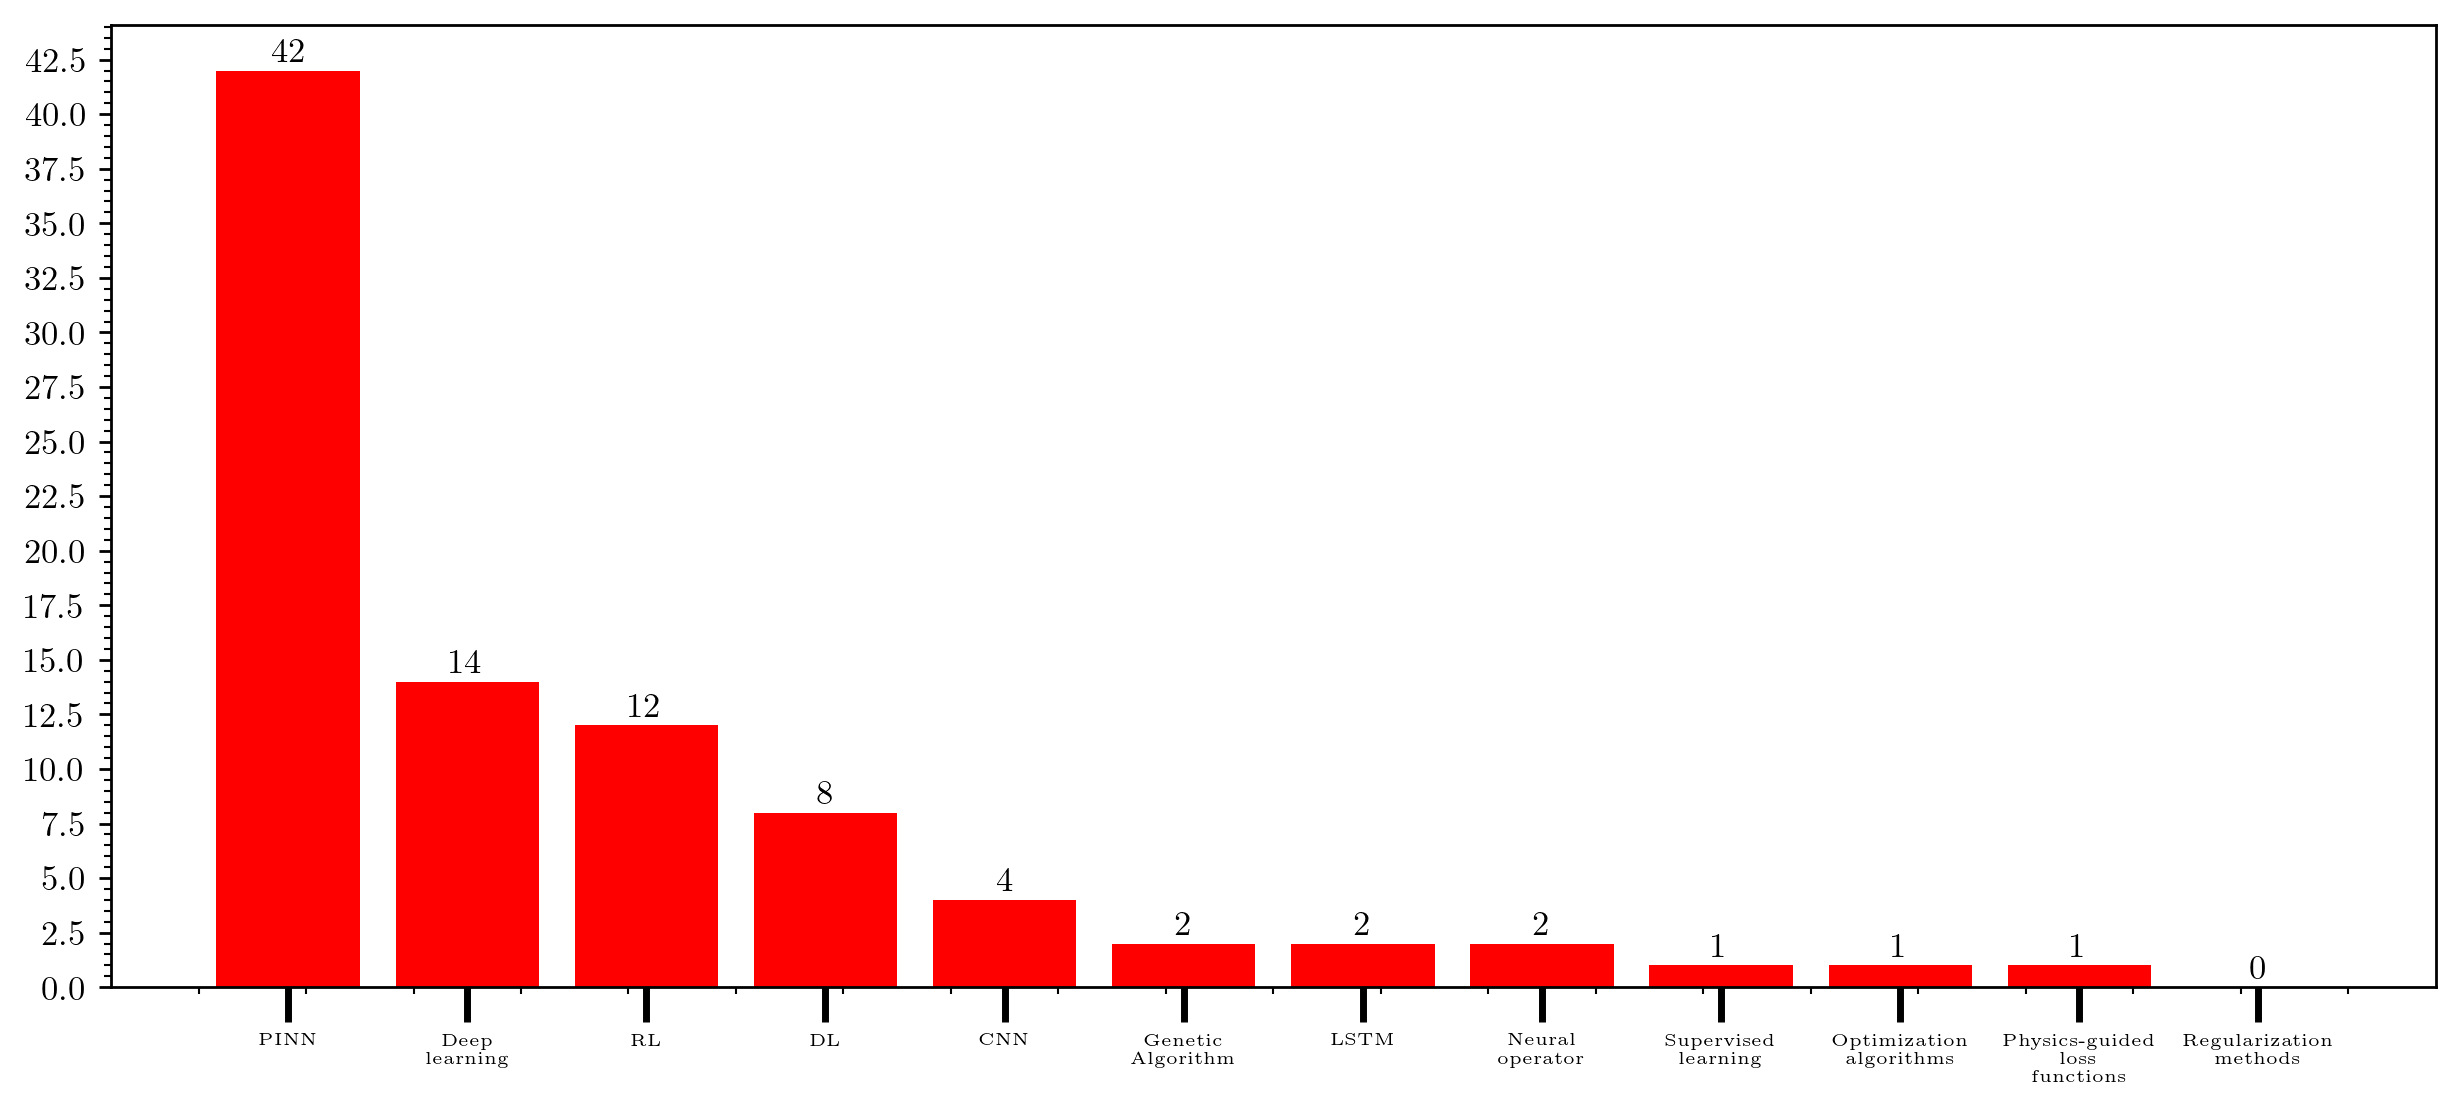

In [4]:
properties = [
    'DNN', 'RL', 'DRL', 'DL', 'Genetic Algorithm', 'LSTM', 'PINN', 'Physics-informed neural networks (PINN)', 'Neural operator', 'Fourier neural operator (FNO)', 'Gaussian processes', 'Reinforcement learning', 'Deep learning', 'Supervised learning', 'SVM' , 'CNN', 'RNN',
    'Unsupervised learning', 'Semi-supervised learning', 'GRU', 'GNN'
    'Autoencoders', 'Variational autoencoders (VAE)', 'Generative adversarial networks (GAN)',
    'Bayesian neural networks', 'Sparse regression', 'Symbolic regression',
    'Support vector machines (SVM)', 'Random forests', 'Gradient boosting',
    'Physics-constrained optimization',
    'Multi-task learning', 'Transfer learning', 'Meta-learning', 
    'Convolutional neural networks (CNN)', 'Recurrent neural networks (RNN)',
    'Long short-term memory (LSTM)', 'Transformers', 'Graph neural networks (GNN)',
    'Physics-guided loss functions', 'Regularization methods', 'Optimization algorithms',
    'Hyperparameter tuning', 'Monte Carlo methods', 'Markov chain Monte Carlo (MCMC)',
    'Probabilistic programming', 'Reinforcement learning for physical systems', 
    'Model-based reinforcement learning', 'Evolutionary algorithms',
    'Bayesian optimization', 'Differentiable programming', 'MLP', 'Causality'
    'Hybrid neural-symbolic learning', 'Active learning'
]

property_frequency = {prop: 0 for prop in properties}
property_titles = {prop: [] for prop in properties}

df_combined_text = (
    df['keyword'].fillna('').str.lower() + ' ' +
    df['title'].fillna('').str.lower() + ' ' +
    df['abstract'].fillna('').str.lower()
)

for prop in properties:
    mask = df_combined_text.str.contains(prop.lower(), case=False)
    property_frequency[prop] = mask.sum()
    property_titles[prop] = df.loc[mask, 'title'].tolist()

# Convert to DataFrame
property_df = pd.DataFrame({
    'Property': list(property_frequency.keys()),
    'Frequency': list(property_frequency.values()),
    'Titles': ['; '.join(titles) for titles in property_titles.values()]
})

# Sort by frequency and filter top 12
property_df = property_df.sort_values(by='Frequency', ascending=False)[:12]

# Plotting
fig, ax = plt.subplots(figsize=(12, 5), dpi=250)
bars = ax.bar(
    property_df['Property'], 
    property_df['Frequency'], 
    width=0.8, 
    color='r'
)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        yval + 0.1,  # Y position (slightly above the bar)
        round(yval, 2),  # The value of the bar, rounded to 2 decimals
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10  # Font size
    )

# Adjust x-axis labels
labels = [label.replace(' ', '\n') for label in property_df['Property']]
_X = np.arange(len(property_df['Property']))
plt.xticks(_X, labels, rotation=0, ha='center', fontsize=6)

# Set y-axis tick intervals
ax.yaxis.set_major_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=5, rotation=0)
ax.set_xticks(range(len(property_df['Property'])))
ax.set_xticks(np.linspace(-0.5, len(property_df['Property']) - 0.5, 21), minor=True)

# Make right and top spines visible
ax.spines[['right', 'top']].set_visible(True)

plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_22352\867424505.py:55: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_22352\867424505.py:55: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)


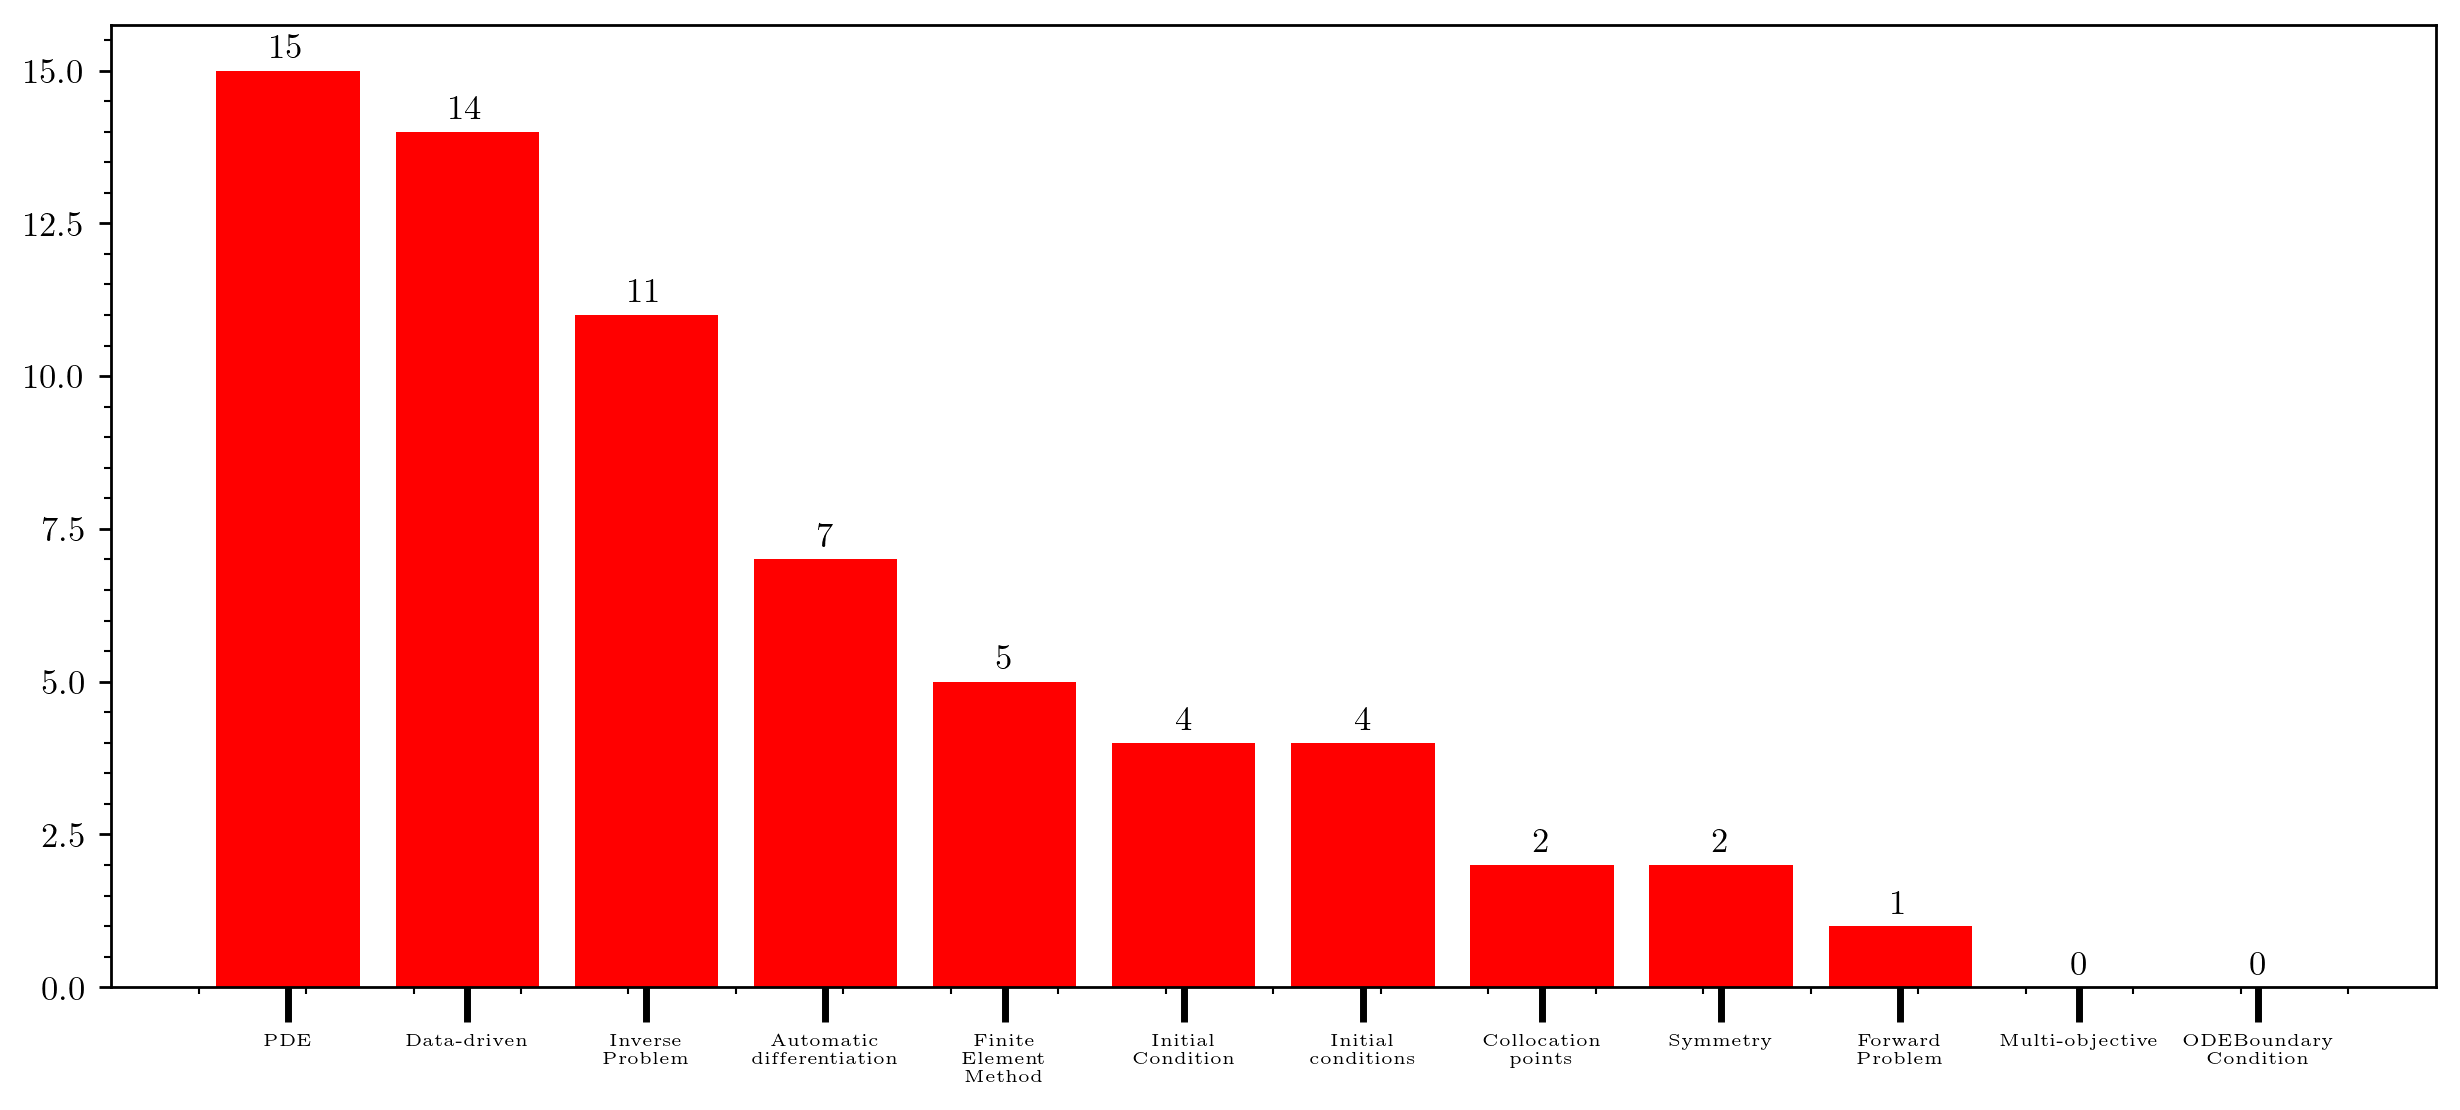

In [5]:
properties = [
        "Governing partial differential equations (PDEs)",
    "Boundary conditions (Dirichlet, Neumann, Robin)",
    "Initial conditions",
    
    # Loss Function Design
    "Physics-based loss",
    "Boundary condition loss",
    "Initial condition loss",
    "Total loss function",

    # Computational Techniques
    "Automatic differentiation",
    "Collocation points",
    "Regularization methods",
    
    # Advanced Techniques
    "Handling discontinuities",
    "High-dimensional PDEs",
    "Parameter inference",
    "Energy conservation",
    "Multi-fidelity learning",
    "Multi-scale resolution",
    
    # Interpretability and Uncertainty
    "Residual visualization",
    "Probabilistic PINNs",
    "Symmetry and invariance embedding",
    "Data-driven physics integration",
    "Reduce Order",
    "Forward Problem",
    "Inverse Problem",
    "Symmetry",
    "Invariant",
    "Equivariant",
    "Koopman",
    "Finite Element Method",
    "Data-driven",
    "Multi-objective",
    "PDE",
    "ODE"
    "Boundary Condition",
    "Initial Condition"
    ]
property_frequency = {prop: 0 for prop in properties}
property_titles = {prop: [] for prop in properties}

df_combined_text = (
    df['keyword'].fillna('').str.lower() + ' ' +
    df['title'].fillna('').str.lower() + ' ' +
    df['abstract'].fillna('').str.lower()
)

for prop in properties:
    mask = df_combined_text.str.contains(prop.lower(), case=False)
    property_frequency[prop] = mask.sum()
    property_titles[prop] = df.loc[mask, 'title'].tolist()

# Convert to DataFrame
property_df = pd.DataFrame({
    'Property': list(property_frequency.keys()),
    'Frequency': list(property_frequency.values()),
    'Titles': ['; '.join(titles) for titles in property_titles.values()]
})

# Sort by frequency and filter top 12
property_df = property_df.sort_values(by='Frequency', ascending=False)[:12]

# Plotting
fig, ax = plt.subplots(figsize=(12, 5), dpi=250)
bars = ax.bar(
    property_df['Property'], 
    property_df['Frequency'], 
    width=0.8, 
    color='r'
)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        yval + 0.1,  # Y position (slightly above the bar)
        round(yval, 2),  # The value of the bar, rounded to 2 decimals
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10  # Font size
    )

# Adjust x-axis labels
labels = [label.replace(' ', '\n') for label in property_df['Property']]
_X = np.arange(len(property_df['Property']))
plt.xticks(_X, labels, rotation=0, ha='center', fontsize=6)

# Set y-axis tick intervals
ax.yaxis.set_major_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=5, rotation=0)
ax.set_xticks(range(len(property_df['Property'])))
ax.set_xticks(np.linspace(-0.5, len(property_df['Property']) - 0.5, 21), minor=True)

# Make right and top spines visible
ax.spines[['right', 'top']].set_visible(True)

plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_22352\2364867268.py:102: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_22352\2364867268.py:102: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_22352\2364867268.py:102: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)


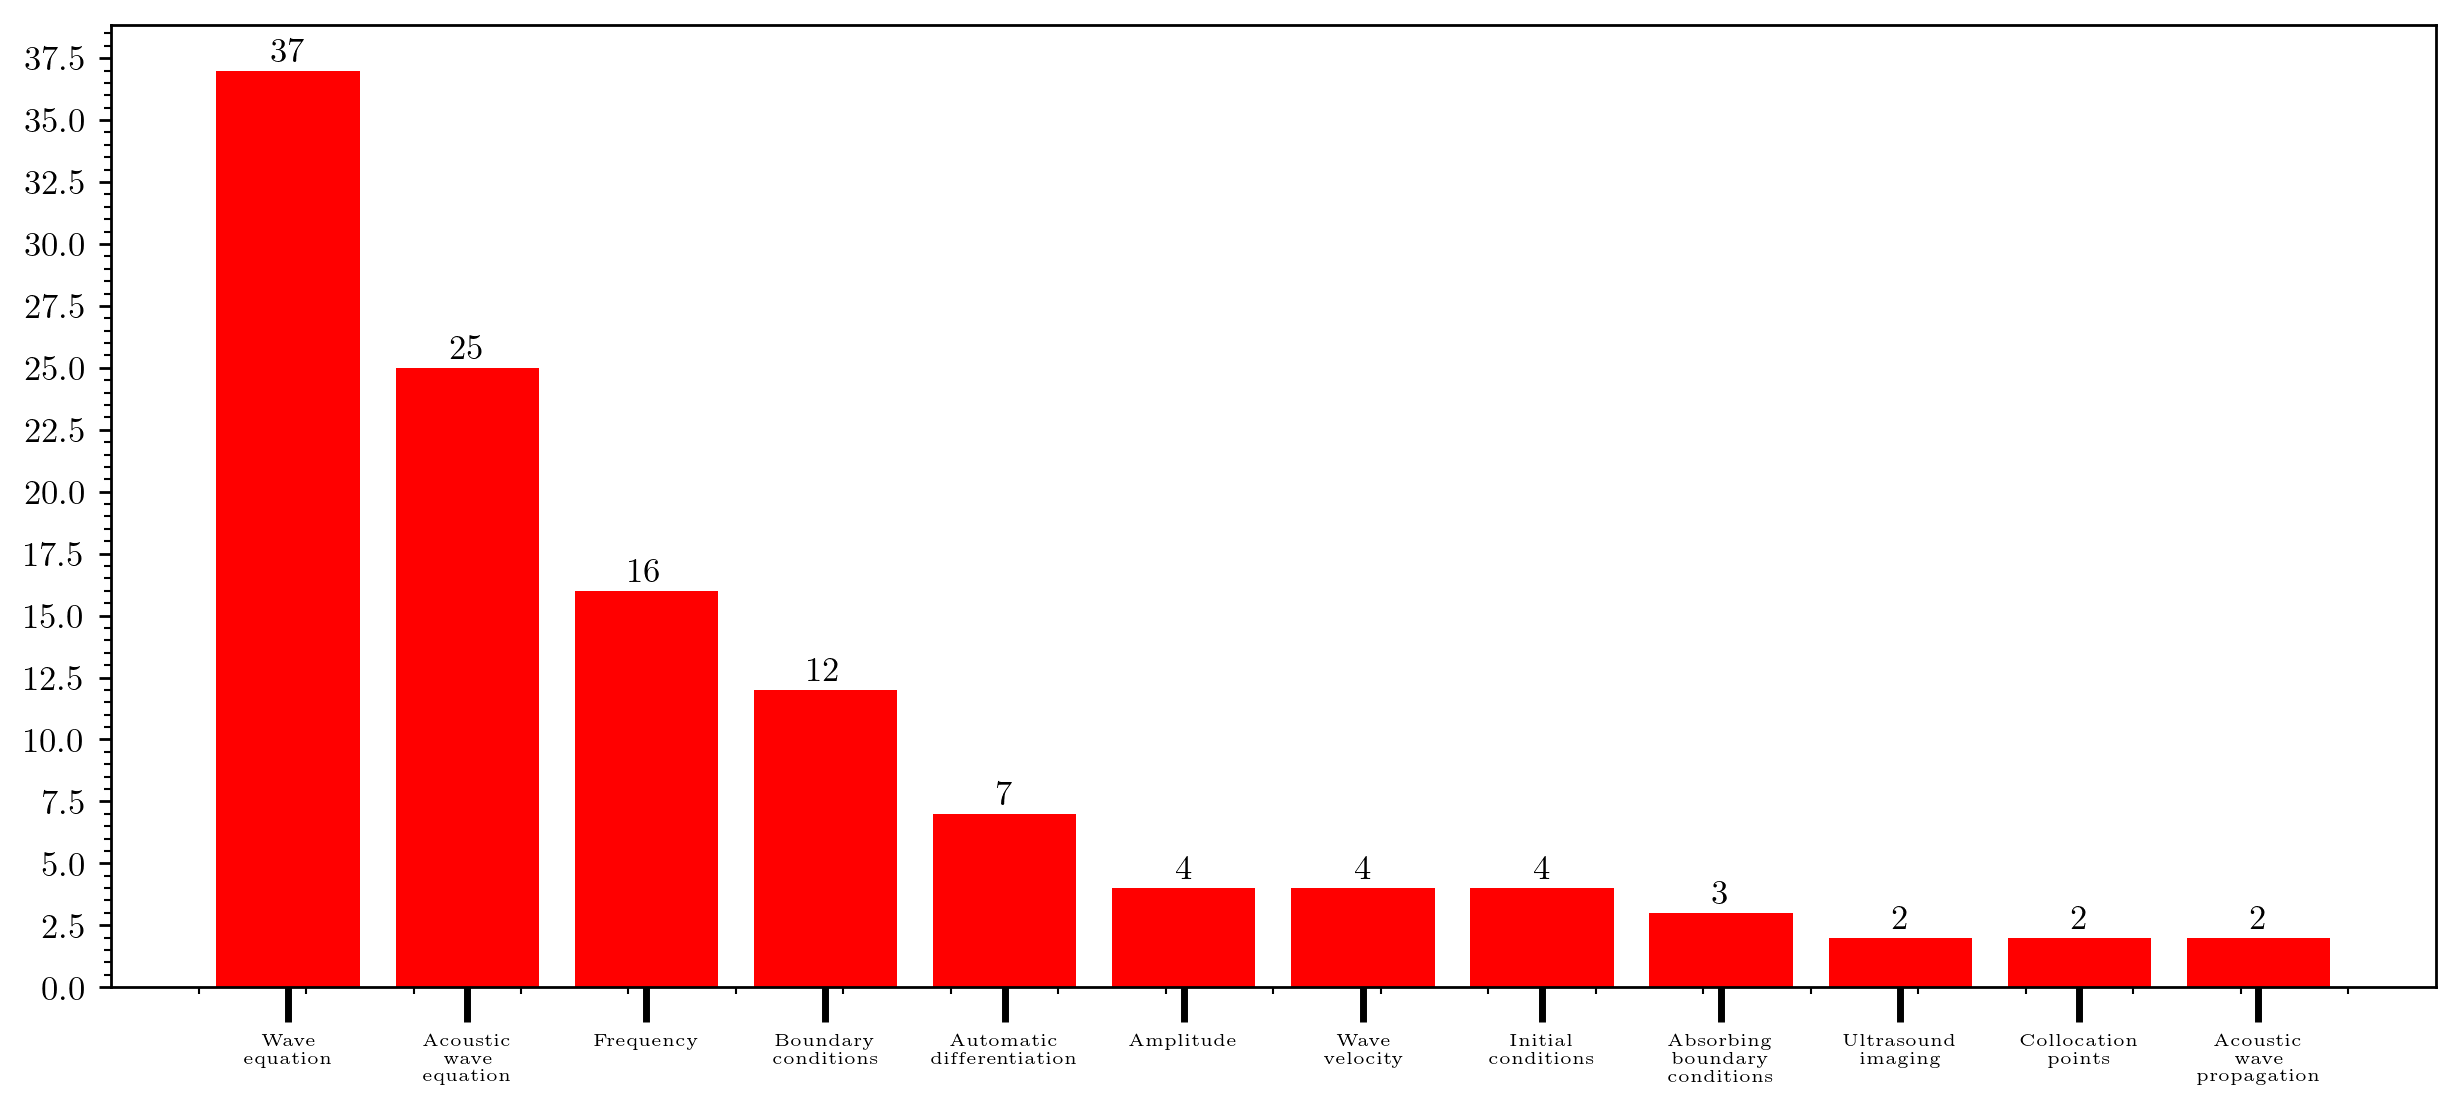

In [7]:
properties = [
    # Governing Equations
    "Wave equation",
    "Acoustic wave equation",
    "Elastic wave equation",
    "Seismic wave equation",
    "Electromagnetic wave equation",
    "Nonlinear wave equations",
    "Dispersion relations",

    # Initial and Boundary Conditions
    "Initial conditions",
    "Boundary conditions",
    "Dirichlet boundary conditions",
    "Neumann boundary conditions",
    "Robin boundary conditions",
    "Periodic boundary conditions",
    "Absorbing boundary conditions",
    "Perfectly Matched Layer (PML)",

    # Wave Characteristics
    "Wave velocity",
    "Phase velocity",
    "Group velocity",
    "Wavelength",
    "Frequency",
    "Amplitude",
    "Attenuation",
    "Reflection and transmission",
    "Scattering effects",
    "Wave interference",
    "Standing waves",
    "Resonance",
    "Stokes Wave",
    "Solitary Wave",

    # Computational Methods in PINNs
    "Collocation points",
    "Automatic differentiation",
    "Physics-based loss functions",
    "Residual minimization",
    "High-dimensional wave problems",
    "Handling discontinuities in waves",
    "Multi-fidelity learning",
    "Inverse modeling of wave parameters",
    "Source term identification",
    "Parameter inference for wave speed",

    # Mathematical Techniques
    "Fourier transforms",
    "Spectral methods",
    "Finite difference methods (FDM)",
    "Finite element methods (FEM)",
    "Rayleigh scattering",
    "Wave superposition principle",
    "Eigenvalue problems for waves",
    "Stability analysis of wave propagation",

    # Advanced PINN Topics
    "Symmetry and invariance in wave physics",
    "Energy conservation in wave propagation",
    "Data assimilation in PINNs",
    "Time-domain and frequency-domain analysis",
    "Multi-scale modeling of waves",
    "Harmonic analysis",
    "Domain decomposition for wave problems",
    "Sparse data reconstruction using PINNs",
    "Uncertainty quantification in wave PINNs",
    "Reduced-order modeling of wave systems",

    # Applications of Wave PINNs
    "Seismic wave modeling",
    "Acoustic wave propagation",
    "Electromagnetic wave analysis",
    "Water wave simulations",
    "Tsunami modeling",
    "Ultrasound imaging",
    "Vibration analysis in structures",
    "Non-destructive testing using waves",
    "Underwater acoustics",
    "Optical wave simulations",
    "Waveguide modeling",
    "Antenna design with wave PINNs",

    # Visualization and Diagnostics
    "Residual visualization",
    "Wavefront tracking",
    "Energy distribution plots",
    "Scattering pattern visualization",
    "Amplitude decay visualization"
]
property_frequency = {prop: 0 for prop in properties}
property_titles = {prop: [] for prop in properties}

df_combined_text = (
    df['keyword'].fillna('').str.lower() + ' ' +
    df['title'].fillna('').str.lower() + ' ' +
    df['abstract'].fillna('').str.lower()
)

for prop in properties:
    mask = df_combined_text.str.contains(prop.lower(), case=False)
    property_frequency[prop] = mask.sum()
    property_titles[prop] = df.loc[mask, 'title'].tolist()

# Convert to DataFrame
property_df = pd.DataFrame({
    'Property': list(property_frequency.keys()),
    'Frequency': list(property_frequency.values()),
    'Titles': ['; '.join(titles) for titles in property_titles.values()]
})

# Sort by frequency and filter top 12
property_df = property_df.sort_values(by='Frequency', ascending=False)[:12]

# Plotting
fig, ax = plt.subplots(figsize=(12, 5), dpi=250)
bars = ax.bar(
    property_df['Property'], 
    property_df['Frequency'], 
    width=0.8, 
    color='r'
)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        yval + 0.1,  # Y position (slightly above the bar)
        round(yval, 2),  # The value of the bar, rounded to 2 decimals
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10  # Font size
    )

# Adjust x-axis labels
labels = [label.replace(' ', '\n') for label in property_df['Property']]
_X = np.arange(len(property_df['Property']))
plt.xticks(_X, labels, rotation=0, ha='center', fontsize=6)

# Set y-axis tick intervals
ax.yaxis.set_major_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=5, rotation=0)
ax.set_xticks(range(len(property_df['Property'])))
ax.set_xticks(np.linspace(-0.5, len(property_df['Property']) - 0.5, 21), minor=True)

# Make right and top spines visible
ax.spines[['right', 'top']].set_visible(True)

plt.show()